In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
tqdm.monitor_interval = 0

In [3]:
RELU = False
FORECAST = 5

In [4]:
dset = Routes('train', 32, index_file='min-data.json')
evalset = Routes('test', 32, index_file='min-data.json')

Routes dataset: train
 [*] Loaded routes: 224 (0.24s)
 [*] Subset train: 204 (reserved_routes.json)
 [*] Loaded trainable inds: 240935 (0.18s)
Routes dataset: test
 [*] Loaded routes: 224 (0.28s)
 [*] Subset test: 20 (reserved_routes.json)
 [*] Loaded trainable inds: 54181 (0.02s)


In [5]:
import torch
import torch.nn as nn
import numpy as np

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
from models.RNN import RNN

In [8]:
model = RNN(relu=RELU, forecast=FORECAST).to(device)

In [9]:
criterion, opt, sch = model.params(lr=0.0001)

In [10]:
torch.save(model, 'checkpoints/temp.pth')

In [11]:
def evaluate():
    eval_losses = []
    for bii in tqdm(range(evalset.size())):
        model.eval()
        
        Xs, Ys = evalset.next()
        Xs, Ys = model.format_batch(Xs, Ys)

        outputs, _ = model(Xs)
        loss = criterion(outputs, Ys)
        eval_losses.append(loss.item())
    print('Eval loss:', np.mean(eval_losses))

In [ ]:
evaluate()

 82%|████████▏ | 1388/1693 [01:16<00:16, 18.25it/s]

In [ ]:
EPS = 5
losses = []
for eii  in range(EPS):
    sch.step()
    for bii in range(dset.size()):
        model.train()
        Xs, Ys = dset.next()
        Xs, Ys = model.format_batch(Xs, Ys)

        outputs, _ = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, dset.size(), 
            loss.item()
        ))
    evaluate()
    torch.save(model, 'checkpoints/rnn_fcast_e%d.pth' % (eii+1))
    sys.stdout.flush()
#     sys.stdout.flush()

In [12]:
model.eval()

RNN(
  (inp): Linear(in_features=5, out_features=128, bias=True)
  (rnn): LSTM(128, 128, num_layers=2, dropout=0.05)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

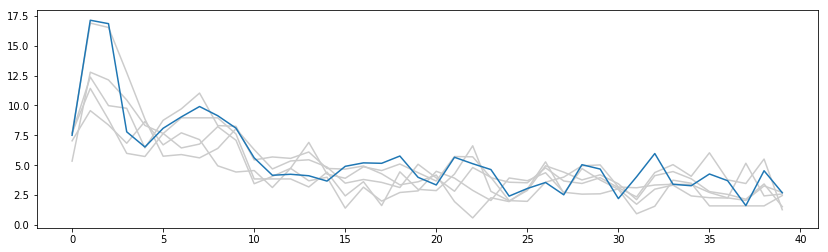

In [34]:
info = evalset.meta[0]
len(info['trainable'])
data = history_byname(info['name'])

row_integs = []
for row in data:
    row_integs.append(np.count_nonzero(np.isnan(row)) / len(row))
iorder = np.argsort(row_integs)
sample = data[ind-6:ind, :]

plt.figure(figsize=(14, 4))
for hi in range(1, 6):
    plt.plot(sample[-hi-1, :], color='#CCCCCC')
plt.plot(sample[-1, :], color='C0')
plt.show(); plt.close()

In [51]:
preds = []
for bi in range(10, sample.shape[1]):
    Xs, Ys = np.array([sample[:5, bi-10:bi]]), np.array([sample[5, bi-10:bi]])
    Xs, Ys = batch_format(Xs, Ys)
    Yguess, _ = model(Xs)
    ys = Yguess.detach().squeeze().cpu().numpy()
    ys = np.flip(ys).copy()
    preds.append(ys)

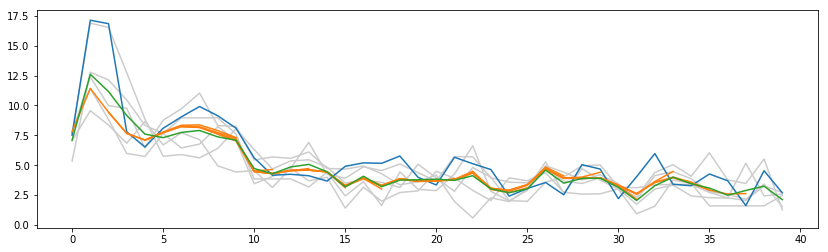

In [53]:
plt.figure(figsize=(14, 4))
for hi in range(1, 6):
    plt.plot(sample[-hi-1, :], color='#CCCCCC')
plt.plot(sample[-1, :], color='C0')
for bi in range(10, sample.shape[1], 2):
    plt.plot(range(bi-10, bi), preds[bi-10], color='C1')
plt.plot(np.mean(sample[:-1, :], 0), color='C2')
plt.show(); plt.close()

In [23]:
tonpy = lambda tens: tens.detach().cpu().numpy()

In [24]:
def show_many(ys, ytrue, many=3):
    ys = tonpy(ys)
    ytrue = tonpy(ytrue)
    plt.figure(figsize=(14, many+1))
    for ii in range(many):
        plt.subplot(many, 1, ii+1)
        
        plt.plot(list(reversed(ys[ii])))
        plt.plot(list(reversed(ytrue[ii])))
    plt.show(); plt.close()

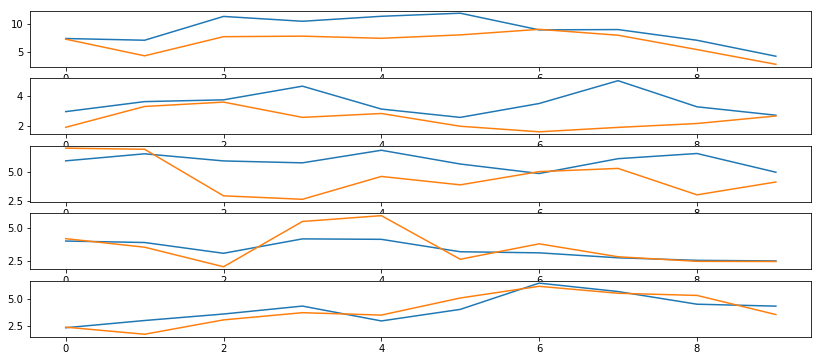

In [25]:
show_many(torch.t(Yguess.squeeze()), Ys, many=5)

100%|██████████| 128/128 [00:05<00:00, 21.34it/s]

Eval loss: 4.701302522793412
